<h1><center> Earthquake Cycle Simulations

In [33]:
@time include("src/setup.jl") 

Total number of nodes on fault = 121
Average node spacing = 400.0
dt = 0.04486312014474891


Setup Complete
  2.166636 seconds (2.52 M allocations: 537.482 MiB, 12.35% gc time)


In [34]:
#simulation_time = @elapsed include("src/timesolver.jl")

@time include("src/timesolver.jl")


Time (yr) = 51.309
Time (yr) = 107.99
Time (yr) = 145.18
Time (yr) = 156.86
Time (yr) = 192.51
Time (yr) = 192.51
Time (yr) = 192.51
Time (yr) = 192.51
Time (yr) = 192.51
Time (yr) = 192.52
Time (yr) = 198.81
Simulation Complete
683.451527 seconds (6.53 G allocations: 1.409 TiB, 11.45% gc time)


In [29]:
using PyPlot

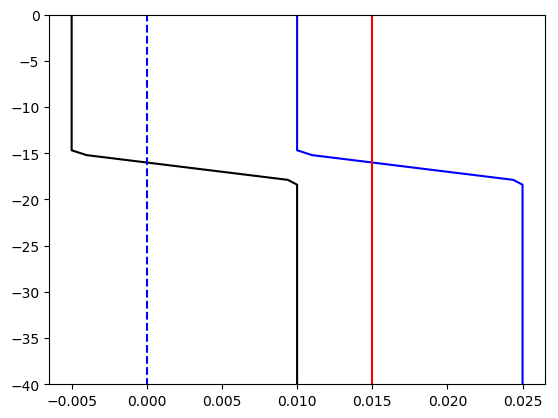

In [32]:
# Plot rate and state friction parameters
plot(cca, FltX/1e3, "b-")
plot(ccb, FltX/1e3, "r-")
plot(cca-ccb, FltX/1e3, "k-")
plot(repmat([0], FaultNglob), FltX/1e3, "b--")
ylim([-40, 0])
show()

<h3> Save the variables to data folder

In [10]:
# Additional variables to be saved

# Description of the simulation
desc = "Elastic halfspace, Fault Zone: 10 km deep, 1km wide"

In [35]:
using JLD

@save "data/benchmark/test01.jld"